[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="400">](https://github.com/jeshraghian/snntorch/)

# snnTorch - The Leaky Integrate and Fire Neuron
## 튜토리얼 2
### 강의: [Jason K. Eshraghian](https://www.ncg.ucsc.edu)
### 번역: [ToToKr](https://github.com/Moerai)
<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/tutorial_2_lif_neuron.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub-Mark-Light-120px-plus.png?raw=true' width="28">](https://github.com/jeshraghian/snntorch/) [<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub_Logo_White.png?raw=true' width="80">](https://github.com/jeshraghian/snntorch/)

snnTorch 튜토리얼 시리즈는 다음 문서를 기반으로 합니다. 이러한 리소스나 코드가 작업에 유용하다고 생각되면 다음 소스를 인용해 주세요:

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". Proceedings of the IEEE, 111(9) September 2023.](https://ieeexplore.ieee.org/abstract/document/10242251) </cite>


# Introduction
이번 튜토리얼에서 당신은:
* leaky integrate-and-fire (LIF) 뉴런 모델의 기초를 배우고
* snnTorch를 사용하여 first order LIF neuron을 구현합니다.

다음 셀을 클릭하고 `Shift+Enter`를 눌러 최신 PyPi 배포판의 snnTorch를 설치합니다.

In [1]:
!pip install snntorch

In [2]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

In [3]:
#@title Plotting Settings
def plot_mem(mem, title=False):
  if title:
    plt.title(title)
  plt.plot(mem)
  plt.xlabel("Time step")
  plt.ylabel("Membrane Potential")
  plt.xlim([0, 50])
  plt.ylim([0, 1])
  plt.show()

def plot_step_current_response(cur_in, mem_rec, vline1):
  fig, ax = plt.subplots(2, figsize=(8,6),sharex=True)

  # Plot input current
  ax[0].plot(cur_in, c="tab:orange")
  ax[0].set_ylim([0, 0.2])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  ax[0].set_title("Lapicque's Neuron Model With Step Input")

  # Plot membrane potential
  ax[1].plot(mem_rec)
  ax[1].set_ylim([0, 0.6])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")

  if vline1:
    ax[1].axvline(x=vline1, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.xlabel("Time step")

  plt.show()


def plot_current_pulse_response(cur_in, mem_rec, title, vline1=False, vline2=False, ylim_max1=False):

  fig, ax = plt.subplots(2, figsize=(8,6),sharex=True)

  # Plot input current
  ax[0].plot(cur_in, c="tab:orange")
  if not ylim_max1:
    ax[0].set_ylim([0, 0.2])
  else:
    ax[0].set_ylim([0, ylim_max1])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem_rec)
  ax[1].set_ylim([0, 1])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")

  if vline1:
    ax[1].axvline(x=vline1, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  if vline2:
    ax[1].axvline(x=vline2, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.xlabel("Time step")

  plt.show()

def compare_plots(cur1, cur2, cur3, mem1, mem2, mem3, vline1, vline2, vline3, vline4, title):
  # Generate Plots
  fig, ax = plt.subplots(2, figsize=(8,6),sharex=True)

  # Plot input current
  ax[0].plot(cur1)
  ax[0].plot(cur2)
  ax[0].plot(cur3)
  ax[0].set_ylim([0, 0.2])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem1)
  ax[1].plot(mem2)
  ax[1].plot(mem3)
  ax[1].set_ylim([0, 1])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")

  ax[1].axvline(x=vline1, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  ax[1].axvline(x=vline2, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  ax[1].axvline(x=vline3, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  ax[1].axvline(x=vline4, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)

  plt.xlabel("Time step")

  plt.show()

def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False, ylim_max2=1.25):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True,
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input current
  ax[0].plot(cur, c="tab:orange")
  ax[0].set_ylim([0, 0.4])
  ax[0].set_xlim([0, 200])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  if title:
    ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, ylim_max2])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk, ax[2], s=400, c="black", marker="|")
  if vline:
    ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.ylabel("Output spikes")
  plt.yticks([])

  plt.show()

def plot_spk_mem_spk(spk_in, mem, spk_out, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True,
                        gridspec_kw = {'height_ratios': [0.4, 1, 0.4]})

  # Plot input current
  splt.raster(spk_in, ax[0], s=400, c="black", marker="|")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)
  plt.yticks([])

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, 1])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  ax[1].axhline(y=0.5, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk_rec, ax[2], s=400, c="black", marker="|")
  plt.ylabel("Output spikes")
  plt.yticks([])

  plt.show()


def plot_reset_comparison(spk_in, mem_rec, spk_rec, mem_rec0, spk_rec0):
  # Generate Plots to Compare Reset Mechanisms
  fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,6), sharex=True,
                        gridspec_kw = {'height_ratios': [0.4, 1, 0.4], 'wspace':0.05})

  # Reset by Subtraction: input spikes
  splt.raster(spk_in, ax[0][0], s=400, c="black", marker="|")
  ax[0][0].set_ylabel("Input Spikes")
  ax[0][0].set_title("Reset by Subtraction")
  ax[0][0].set_yticks([])

  # Reset by Subtraction: membrane potential
  ax[1][0].plot(mem_rec)
  ax[1][0].set_ylim([0, 0.7])
  ax[1][0].set_ylabel("Membrane Potential ($U_{mem}$)")
  ax[1][0].axhline(y=0.5, alpha=0.25, linestyle="dashed", c="black", linewidth=2)

  # Reset by Subtraction: output spikes
  splt.raster(spk_rec, ax[2][0], s=400, c="black", marker="|")
  ax[2][0].set_yticks([])
  ax[2][0].set_xlabel("Time step")
  ax[2][0].set_ylabel("Output Spikes")

  # Reset to Zero: input spikes
  splt.raster(spk_in, ax[0][1], s=400, c="black", marker="|")
  ax[0][1].set_title("Reset to Zero")
  ax[0][1].set_yticks([])

  # Reset to Zero: membrane potential
  ax[1][1].plot(mem_rec0)
  ax[1][1].set_ylim([0, 0.7])
  ax[1][1].axhline(y=0.5, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  ax[1][1].set_yticks([])
  ax[2][1].set_xlabel("Time step")

  # Reset to Zero: output spikes
  splt.raster(spk_rec0, ax[2][1], s=400, c="black", marker="|")
  ax[2][1].set_yticks([])

  plt.show()

# 1. The Spectrum of Neuron Models
생물물리학적으로 정확한 모델(예: 호지킨-헉슬리 모델)부터 현대 딥러닝의 모든 측면에 퍼져 있는 매우 단순한 인공 뉴런에 이르기까지 매우 다양한 뉴런 모델이 존재합니다.

**호지킨-헉슬리 뉴런 모델**$-$생물물리학적 모델은 전기생리학적 결과를 높은 정확도로 재현할 수 있지만, 그 복잡성 때문에 현재로서는 사용하기가 어렵습니다.

**인공 뉴런 모델**$-$다른 한편으로는 인공 뉴런이 있습니다. 입력에 해당 가중치를 곱하고 활성화 함수를 통과시킵니다. 이러한 단순화 덕분에 딥러닝 연구자들은 컴퓨터 비전, 자연어 처리 및 기타 여러 머신러닝 영역의 작업에서 놀라운 업적을 달성할 수 있었습니다.

**Leaky Integrate-and-Fire Neuron Models**$-$이 둘의 중간쯤에 Leaky Integrate-and-Fire (LIF) 뉴런 모델이 있습니다. 이 모델은 인공 뉴런과 마찬가지로 가중치 입력의 합을 취합니다. 하지만 활성화 함수에 직접 전달하지 않고 RC 회로처럼 누설을 통해 시간에 따른 입력을 통합합니다. 통합된 값이 임계값을 초과하면 LIF 뉴런은 전압 스파이크를 방출합니다. LIF 뉴런은 출력 스파이크의 모양과 프로파일을 추상화하여 단순히 불연속적인 이벤트로 처리합니다. 따라서 정보는 스파이크 내에 저장되지 않고 스파이크의 타이밍(또는 빈도)만 저장됩니다. 단순한 스파이크 뉴런 모델은 신경 코드, 메모리, 네트워크 역학, 그리고 최근에는 딥 러닝에 대한 많은 통찰력을 제공해 왔습니다. LIF 뉴런은 생물학적 타당성과 실용성 사이의 중간 지점에 위치합니다.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_1_neuronmodels.png?raw=true' width="1000">
</center>


다양한 버전의 LIF 모델에는 각각 고유한 역학 관계와 사용 사례가 있습니다. snnTorch는 현재 다음과 같은 LIF 뉴런을 지원합니다:
* Lapicque's RC model: ``snntorch.Lapicque``
* 1st-order model: ``snntorch.Leaky``
* Synaptic Conductance-based neuron model: ``snntorch.Synaptic``
* Recurrent 1st-order model: ``snntorch.RLeaky``
* Recurrent Synaptic Conductance-based neuron model: ``snntorch.RSynaptic``
* Alpha neuron Model: ``snntorch.Alpha``

다른 몇 가지 비-LIF 스파이크 뉴런도 사용할 수 있습니다. 이 튜토리얼에서는 이러한 모델 중 첫 번째 모델에 초점을 맞춥니다. 이는 [subsequent tutorials](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)의 다른 모델을 구축하는 데 사용됩니다.

# 2. The Leaky Integrate-and-Fire Neuron Model

## 2.1 Spiking Neurons: Intuition

우리 뇌에서 뉴런은 1,000~10,000개의 다른 뉴런과 연결되어 있을 수 있습니다. 하나의 뉴런이 급증하면 아래쪽의 모든 뉴런이 이를 느낄 수 있습니다. 그렇다면 뉴런의 스파이크 여부는 무엇이 결정할까요? 지난 한 세기 동안의 실험에 따르면 뉴런이 입력되는 자극이 **충분**하면 흥분하여 스스로 스파이크를 발사할 수 있다는 사실이 밝혀졌습니다.

자극은 어디로부터 오는 걸까요?:
* 감각 주변부(the sensory periphery),
* 인위적으로 뉴런을 자극하는 침습적 전극,
* 다른 시냅스 전 신경세포

로 부터 올 수 있습니다.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_2_intuition.png?raw=true' width="500">
</center>

이러한 스파이크가 매우 짧은 전기 활동이라는 점을 고려할 때, 모든 입력 스파이크가 뉴런 본체에 정확하게 동시에 도착할 가능성은 매우 낮습니다. 이는 입력 스파이크를 '지속'하는 시간적 역학이 존재한다는 것을 나타냅니다(일종의 지연과 같은).



## 2.2 The Passive Membrane

모든 세포와 마찬가지로 뉴런은 얇은 막으로 둘러싸여 있습니다. 이 막은 뉴런 내부의 전도성 식염수를 세포 외 매질로부터 절연하는 지질 이중층입니다. 전기적으로 절연체에 의해 분리된 두 전도성 용액은 커패시터 역할을 합니다.

이 막의 또 다른 기능은 이 세포로 들어오고 나가는 이온(예: Na $^+$ 와 같은 이온)을 제어하는 것입니다. 이 막은 일반적으로 이온에 불투과성이므로 이온이 뉴런 본체로 들어오고 나가는 것을 차단합니다. 그러나 막에는 뉴런에 전류를 주입하여 열리도록 트리거되는 특정 채널이 있습니다. 이 전하 이동은 저항에 의해 전기적으로 모델링됩니다.

* membrane potential은 막 전위로 번역하였습니다.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_3_passivemembrane.png?raw=true' width="450">
</center>

다음 블록에서는 LIF 뉴런의 동작을 처음부터 다시 도출해 보겠습니다. 계산을 건너뛰고 싶으시다면 그냥 넘어가셔도 됩니다. 도출 후 LIF 뉴런의 역학을 이해하는 데 좀 더 실습적인 접근 방식을 취하겠습니다.


---
**Optional: Derivation of LIF Neuron Model**

이제 전기 자극을 통해 또는 다른 뉴런으로부터 시간에 따라 변화하는 임의의 전류 $I_{\rm in}(t)$ 가 뉴런에 주입된다고 가정합니다. 회로의 총 전류는 보존됩니다:

$$I_{\rm in}(t) = I_{R} + I_{C}$$

옴의 법칙에 따르면 뉴런의 내부와 외부 사이에서 측정된 막 전위 $U_{\rm mem}$ 는 저항을 통과하는 전류에 비례합니다:

$$I_{R}(t) = \frac{U_{\rm mem}(t)}{R}$$

Capacitance는 커페시터 $Q$ 에 저장된 전하와 $U_{\rm mem}(t)$ 사이의 비례 상수입니다:


$$Q = CU_{\rm mem}(t)$$

전하 변화율은 capacitive 전류를 나타냅니다:

$$\frac{dQ}{dt}=I_C(t) = C\frac{dU_{\rm mem}(t)}{dt}$$

그러므로:

$$I_{\rm in}(t) = \frac{U_{\rm mem}(t)}{R} + C\frac{dU_{\rm mem}(t)}{dt}$$

$$\implies RC \frac{dU_{\rm mem}(t)}{dt} = -U_{\rm mem}(t) + RI_{\rm in}(t)$$

방정식의 오른쪽은 **\[Voltage]** 단위입니다. 방정식의 왼쪽에 있는 $\frac{dU_{\rm mem}(t)}{dt}$ 항은 **\[Voltage/Time]** 단위 입니다. 이를 왼쪽(즉, 전압)과 동일시하려면 $RC$는 **\[Time]** 단위여야 합니다. 우리는 회로의 시간 상수를 $\tau = RC$ 라고 부릅니다:

$$ \tau \frac{dU_{\rm mem}(t)}{dt} = -U_{\rm mem}(t) + RI_{\rm in}(t)$$

따라서 Passive 멤브레인은 선형 미분 방정식으로 설명할 수 있습니다.

함수의 도함수가 원래 함수와 같은 형태 즉, $\frac{dU_{\rm mem}(t)}{dt} \propto U_{\rm mem}(t)$ 의 형태를 갖기 위해서는 해가 시간 상수 $\tau$ 를 갖는 지수임을 의미합니다.

뉴런이 더 이상 입력이 없는 어떤 값 $U_{0}$, 즉  $I_{\rm in}(t)=0$ 에서 시작한다고 가정합니다. 선형 미분방정식의 해는 다음과 같습니다:

$$U_{\rm mem}(t) = U_0e^{-\frac{t}{\tau}}$$

일반적인 Solution은 아래와 같습니다.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_4_RCmembrane.png?raw=true' width="500">
</center>

---

**Optional: Forward Euler Method to Solving the LIF Neuron Model**

LIF 뉴런에 대한 분석적 해법을 찾았지만, 이것이 신경망에서 어떻게 유용하게 사용될 수 있는지는 불분명합니다. 이번에는 대신 순방향 오일러 방법을 사용해 이전의 선형 편미분 방정식(ODE)을 풀어보겠습니다. 이 접근 방식은 힘들어 보일 수 있지만, LIF 뉴런의 불연속적이고 반복적인 표현을 가능하게 해줍니다. 이 해에 도달하면 신경망에 바로 적용할 수 있습니다. 이전과 마찬가지로 RC 회로를 설명하는 선형 ODE는 다음과 같습니다:

$$\tau \frac{dU(t)}{dt} = -U(t) + RI_{\rm in}(t)$$

$U(t)$ 의 첨자는 단순화를 위해 생락했습니다.

먼저 $\Delta t \rightarrow 0$ 이 미분을 limit를 취하지 않고 풀어봅시다:

$$\tau \frac{U(t+\Delta t)-U(t)}{\Delta t} = -U(t) + RI_{\rm in}(t)$$

충분히 작은 $\Delta t$ 의 경우, 이것은 continuous-time 적분의 근사치를 충분히 제공합니다. 다음 time step에서 멤브레인을 분리하면 다음과 같은 결과가 나옵니다:

$$U(t+\Delta t) = U(t) + \frac{\Delta t}{\tau}\big(-U(t) + RI_{\rm in}(t)\big)$$

아래 함수는 이 방정식을 나타냅니다:

In [4]:
def leaky_integrate_neuron(U, time_step=1e-3, I=0, R=5e7, C=1e-10):
  tau = R*C
  U = U + (time_step/tau)*(-U + I*R)
  return U

기본값은 $R=50 M\Omega$ 와 $C=100pF$ (i.e., $\tau=5ms$)로 설정되어 있습니다. 이는 생물학적 뉴런과 관련하여 매우 현실적입니다.

이제 이 함수를 반복하여 한 번에 one time step씩 반복합니다.

막 전위는 주입된 입력 전류가 없다고 가정하여 $U=0.9 V$로 초기화 되며, $I_{\rm in}=0 A$ 입니다.

시뮬레이션은 밀리초 단위의 정밀도 $\Delta t=1\times 10^{-3}$ s로 수행됩니다.

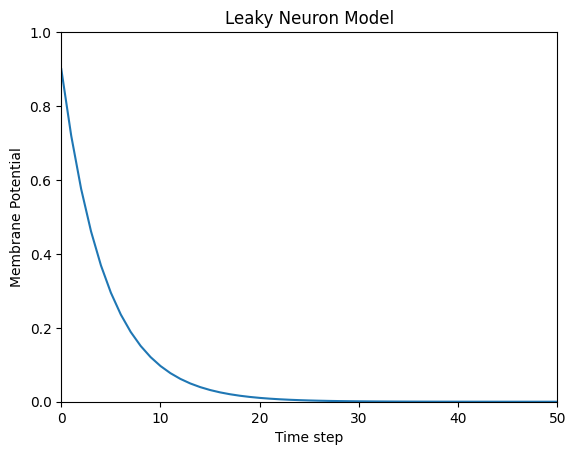

In [5]:
num_steps = 100
U = 0.9
U_trace = []  # keeps a record of U for plotting

for step in range(num_steps):
  U_trace.append(U)
  U = leaky_integrate_neuron(U)  # solve next step of U

plot_mem(U_trace, "Leaky Neuron Model")

이 기하급수적인 쇠퇴는 저희가 예상했던 것과 일치하는 것 같습니다!

# 3 Lapicque's LIF Neuron Model

신경막과 RC 회로 사이의 이러한 유사성은 [Louis Lapicque in 1907](https://core.ac.uk/download/pdf/21172797.pdf)와 같은 방법으로 관찰되었습니다. 그는 짧은 전기 펄스로 개구리의 신경 섬유를 자극하여 신경 세포막을 누설이 있는 커패시터로 근사화할 수 있다는 사실을 발견했습니다. 저희는 그의 발견에 경의를 표하기 위해 snnTorch의 기본 LIF 뉴런 모델 이름을 그의 이름을 따서 명명했습니다.

라피크 모델의 대부분의 개념은 다른 LIF 뉴런 모델에도 그대로 적용됩니다. 이제 snnTorch를 사용하여 이 뉴런을 시뮬레이션해 보겠습니다.

## 3.1 Lapicque: Without Stimulus

다음 코드 줄을 사용하여 라피크의 뉴런을 인스턴스화합니다. 이전 시간 상수인 $\tau=5\times10^{-3}$ 초를 유지하면서 R과 C를 더 간단한 값으로 변경합니다..

In [6]:
time_step = 1e-3
R = 5
C = 1e-3

# leaky integrate and fire neuron, tau=5e-3
lif1 = snn.Lapicque(R=R, C=C, time_step=time_step)

이제 뉴런 모델이 `lif1`에 저장됩니다. 이 뉴런을 사용하려면:

**Inputs**
* `spk_in`: $I_{\rm in}$ 의 각 요소가 순차적으로 input으로 전달(현재는 0).
* `mem`: 이전에 $U[t]$ 였던 막 전위도 input으로 전달 됨. 그리고 $U[0] = 0.9~V$ 로 독단적으로 초기화 됨.

**Outputs**
* `spk_out`: 다음 time step에서 output 스파이크 $S_{\rm out}[t+\Delta t]$ 를 반환(스파이크가 있으면 '1', 없으면 '0').
* `mem`: 다음 time step에서 막 전위 $U_{\rm mem}[t+\Delta t]$

이들은 모두 `torch.Tensor` Type이어야 합니다.


In [7]:
# Initialize membrane, input, and output
mem = torch.ones(1) * 0.9  # U=0.9 at t=0
cur_in = torch.zeros(num_steps)  # I=0 for all t
spk_out = torch.zeros(1)  # initialize output spikes

$t=0$ 값은 초기 시간 단계에만 적용됩니다.

시간 경과에 따른 `mem`의 변화를 분석하려면 `mem_rec` 목록을 만들어 모든 Time Step에서 이러한 값을 기록합니다.

In [8]:
# A list to store recordings of membrane potential
mem_rec = [mem]

이제 시뮬레이션을 실행할 차례입니다! 각 Time step마다 `mem`이 업데이트되어 `mem_rec`에 저장됩니다:

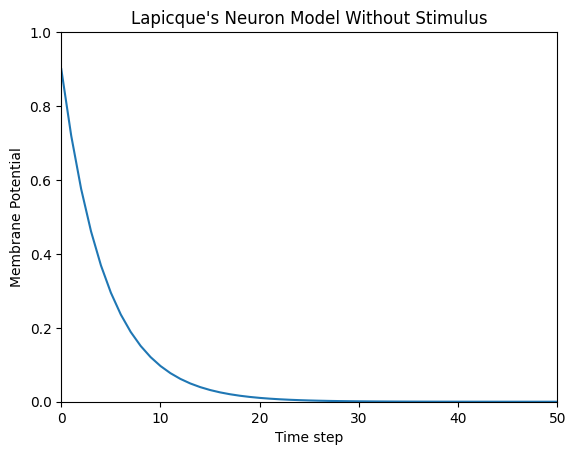

In [9]:
# pass updated value of mem and cur_in[step]=0 at every time step
for step in range(num_steps):
  spk_out, mem = lif1(cur_in[step], mem)

  # Store recordings of membrane potential
  mem_rec.append(mem)

# crunch the list of tensors into one tensor
mem_rec = torch.stack(mem_rec)

plot_mem(mem_rec, "Lapicque's Neuron Model Without Stimulus")

막 전위는 입력 자극이 없을 때 시간이 지남에 따라 감소합니다.

## 3.2 Lapicque: Step Input

이제 $t=t_0$ 에서 켜지는 Step Current $I_{\rm in}(t)$ 를 적용합니다. 아래와 같이 선형 1차 방정식이 주어집니다:

$$ \tau \frac{dU_{\rm mem}}{dt} = -U_{\rm mem} + RI_{\rm in}(t),$$

일반적인 솔루션은 아래와 같습니다:

$$U_{\rm mem}=I_{\rm in}(t)R + [U_0 - I_{\rm in}(t)R]e^{-\frac{t}{\tau}}$$

막 전위가 다음과 같이 초기화 되면 $U_{\rm mem}(t=0) = 0 V$, 아래와 같습니다:

$$U_{\rm mem}(t)=I_{\rm in}(t)R [1 - e^{-\frac{t}{\tau}}]$$

이 명시적인 Time-dependent에 기반하여, $U_{\rm mem}$ 가 $I_{\rm in}R$ 로 기하급수적으로 완화될 것으로 예상합니다. $t_0 = 10ms$ 에서 $I_{in}=100mA$ 의 전류 펄스를 트리거하여 이것이 어떻게 보이는지 시각화해 보겠습니다.

In [10]:
# Initialize input current pulse
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*0.1), 0)  # input current turns on at t=10

# Initialize membrane, output and recordings
mem = torch.zeros(1)  # membrane potential of 0 at t=0
spk_out = torch.zeros(1)  # neuron needs somewhere to sequentially dump its output spikes
mem_rec = [mem]

이번에는 `cur_in` 의 새 값이 뉴런에 전달됩니다:

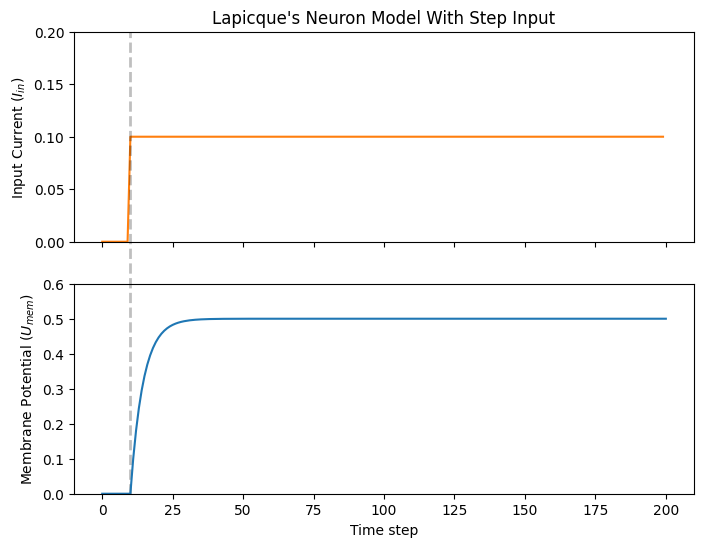

In [11]:
num_steps = 200

# pass updated value of mem and cur_in[step] at every time step
for step in range(num_steps):
  spk_out, mem = lif1(cur_in[step], mem)
  mem_rec.append(mem)

# crunch -list- of tensors into one tensor
mem_rec = torch.stack(mem_rec)

plot_step_current_response(cur_in, mem_rec, 10)

$t\rightarrow \infty$ 에 따라, 멤브레인 포텐셜 $U_{\rm mem}$ 는 기하급수적으로 $I_{\rm in}R$ 로 릴렉스해집니다:

In [12]:
print(f"The calculated value of input pulse [A] x resistance [Ω] is: {cur_in[11]*lif1.R} V")
print(f"The simulated value of steady-state membrane potential is: {mem_rec[200][0]} V")

The calculated value of input pulse [A] x resistance [Ω] is: 0.5 V
The simulated value of steady-state membrane potential is: 0.4999999403953552 V


이 정도면 충분합니다!

## 3.3 Lapicque: Pulse Input

이제 input step이 $t=30ms$ 에서 잘렸다면 어떻게 될까요?

In [13]:
# Initialize current pulse, membrane and outputs
cur_in1 = torch.cat((torch.zeros(10), torch.ones(20)*(0.1), torch.zeros(170)), 0)  # input turns on at t=10, off at t=30
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec1 = [mem]

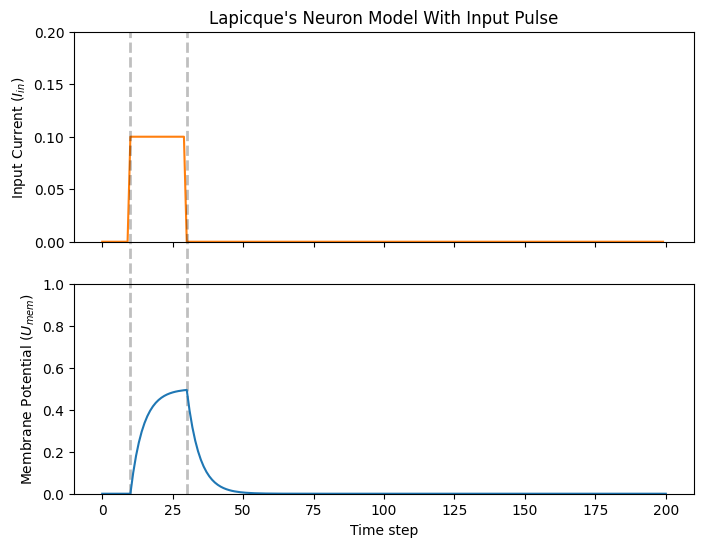

In [14]:
# neuron simulation
for step in range(num_steps):
  spk_out, mem = lif1(cur_in1[step], mem)
  mem_rec1.append(mem)
mem_rec1 = torch.stack(mem_rec1)

plot_current_pulse_response(cur_in1, mem_rec1, "Lapicque's Neuron Model With Input Pulse",
                            vline1=10, vline2=30)

$U_{\rm mem}$는 input step에서와 마찬가지로 상승하지만, 첫 번째 시뮬레이션에서와 같이 $\tau$ 의 시간 상수와 함께 감소합니다.

대략 같은 양의 전하 $Q = I \times t$ 를 절반의 시간 동안 회로에 전달한다고 가정해보겠습니다. 즉, 입력 전류 진폭을 약간 늘리고 Time window를 줄여야 한다는 의미입니다.

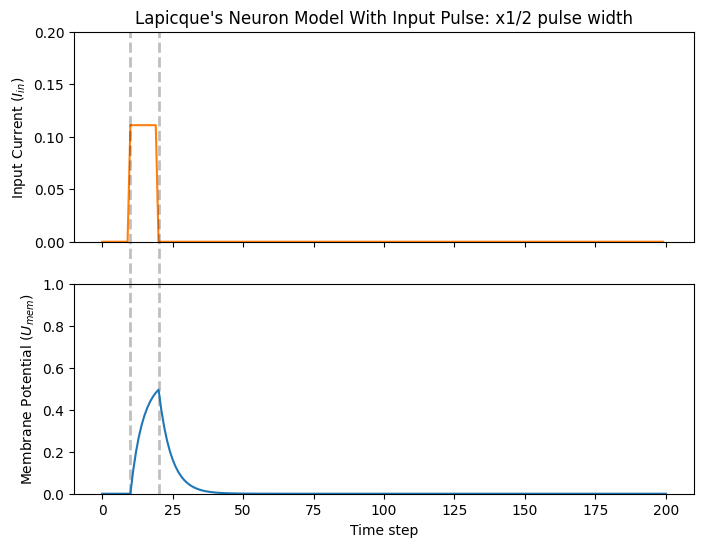

In [15]:
# Increase amplitude of current pulse; half the time.
cur_in2 = torch.cat((torch.zeros(10), torch.ones(10)*0.111, torch.zeros(180)), 0)  # input turns on at t=10, off at t=20
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec2 = [mem]

# neuron simulation
for step in range(num_steps):
  spk_out, mem = lif1(cur_in2[step], mem)
  mem_rec2.append(mem)
mem_rec2 = torch.stack(mem_rec2)

plot_current_pulse_response(cur_in2, mem_rec2, "Lapicque's Neuron Model With Input Pulse: x1/2 pulse width",
                            vline1=10, vline2=20)

더 빠른 입력 펄스와 더 높은 진폭으로 다시 해보겠습니다:

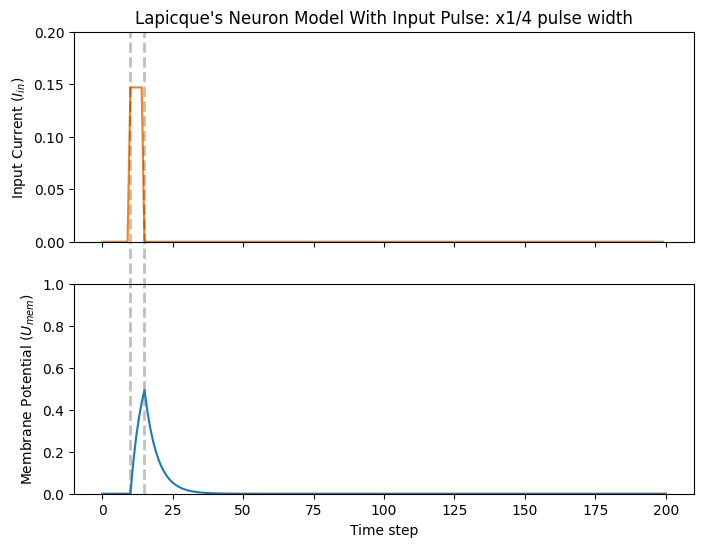

In [16]:
# Increase amplitude of current pulse; quarter the time.
cur_in3 = torch.cat((torch.zeros(10), torch.ones(5)*0.147, torch.zeros(185)), 0)  # input turns on at t=10, off at t=15
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec3 = [mem]

# neuron simulation
for step in range(num_steps):
  spk_out, mem = lif1(cur_in3[step], mem)
  mem_rec3.append(mem)
mem_rec3 = torch.stack(mem_rec3)

plot_current_pulse_response(cur_in3, mem_rec3, "Lapicque's Neuron Model With Input Pulse: x1/4 pulse width",
                            vline1=10, vline2=15)

이제 동일한 플롯에서 세 가지 실험을 모두 비교합니다:

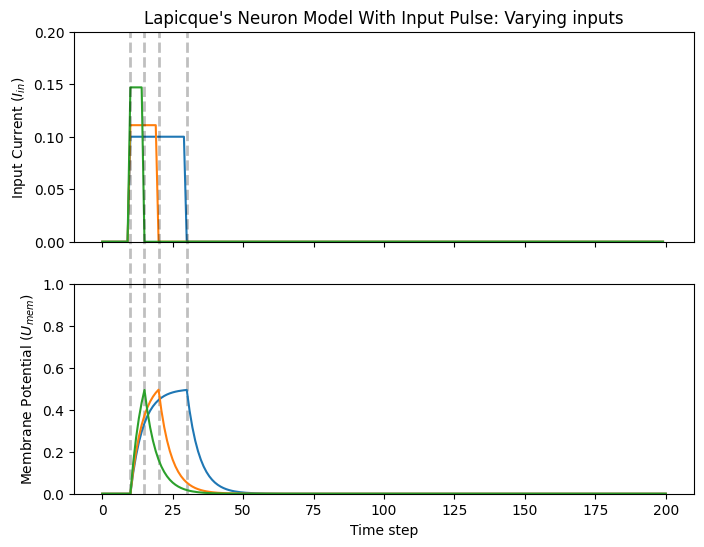

In [17]:
compare_plots(cur_in1, cur_in2, cur_in3, mem_rec1, mem_rec2, mem_rec3, 10, 15,
              20, 30, "Lapicque's Neuron Model With Input Pulse: Varying inputs")

입력 전류 펄스 진폭이 증가함에 따라 막 전위의 상승 시간이 빨라집니다. 입력 전류 펄스 폭이 무한히 작아지는 한계인 $T_W \rightarrow 0s$ 에서는, 막전위가 상숭시간이 거의 0에 가깝게 올라갑니다:

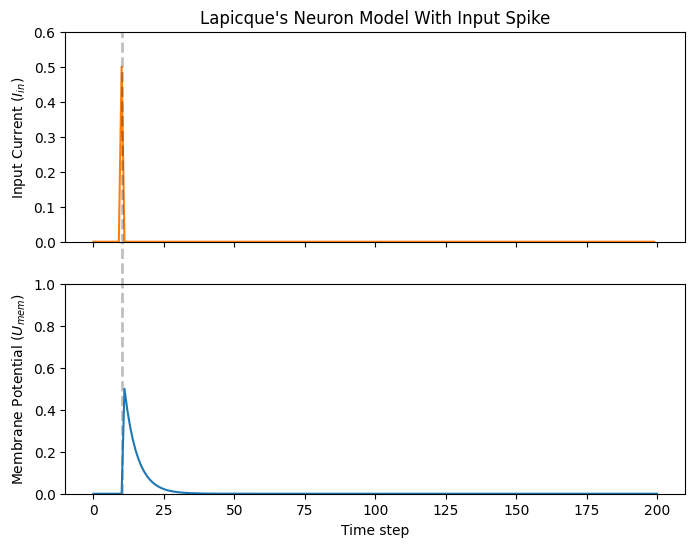

In [18]:
# Current spike input
cur_in4 = torch.cat((torch.zeros(10), torch.ones(1)*0.5, torch.zeros(189)), 0)  # input only on for 1 time step
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec4 = [mem]

# neuron simulation
for step in range(num_steps):
  spk_out, mem = lif1(cur_in4[step], mem)
  mem_rec4.append(mem)
mem_rec4 = torch.stack(mem_rec4)

plot_current_pulse_response(cur_in4, mem_rec4, "Lapicque's Neuron Model With Input Spike",
                            vline1=10, ylim_max1=0.6)

현재 펄스 폭이 너무 짧아서 사실상 스파이크처럼 보입니다. 즉, 전하가 무한히 짧은 시간 내에 전달되며, $I_{\rm in}(t) = Q/t_0$ 에서 $t_0 \rightarrow 0$ 입니다. 좀 더 formall하게 접근해 보자면 아래와 같습니다:

$$I_{\rm in}(t) = Q \delta (t-t_0),$$

여기서 $\delta (t-t_0)$ is the Dirac-Delta 함수 입니다. 물리적으로 전하를 '순간적으로' 충전 하는 것은 불가능합니다. 하지만 $I_{\rm in}$ 를 적분하면 전달된 전하를 얻을 수 있으므로 물리적으로 이해가 되는 결과를 얻을 수 있습니다.

$$1 = \int^{t_0 + a}_{t_0 - a}\delta(t-t_0)dt$$

$$f(t_0) = \int^{t_0 + a}_{t_0 - a}f(t)\delta(t-t_0)dt$$

여기서, $f(t_0) = I_{\rm in}(t_0=10) = 0.5A \implies f(t) = Q = 0.5C$.


이제 막 전위가 어떻게 누설되고 입력 전류가 어떻게 통합되는지 잘 이해하셨기를 바랍니다. 여기까지 뉴런의 '누설(Leaky)'과 '통합(Integrate)' 부분을 설명했습니다. 그럼 발화(Fire)는 어떨까요?

## 3.4 Lapicque: Firing

지금까지는 뉴런이 입력에서 스파이크에 어떻게 반응하는지만 살펴봤습니다. 뉴런이 출력에서 자체 스파이크를 생성하고 방출하려면 수동 멤브레인 모델에 임계값을 결합해야 합니다.

멤브레인 전위가 이 임계값을 초과하면 수동 멤브레인 모델 외부에서 전압 스파이크가 생성됩니다.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_4_spiking.png?raw=true' width="450">
</center>

스파이크 응답을 추가하기 위해 먼저 `leaky_integrate_neuron` 함수를 수정합니다.

In [19]:
# R=5.1, C=5e-3 for illustrative purposes
def leaky_integrate_and_fire(mem, cur=0, threshold=1, time_step=1e-3, R=5.1, C=5e-3):
  tau_mem = R*C
  spk = (mem > threshold) # if membrane exceeds threshold, spk=1, else, 0
  mem = mem + (time_step/tau_mem)*(-mem + cur*R)
  return mem, spk

`threshold=1`으로 설정하고 step 전류를 적용하여 이 뉴런이 스파이크를 일으키도록 합니다.

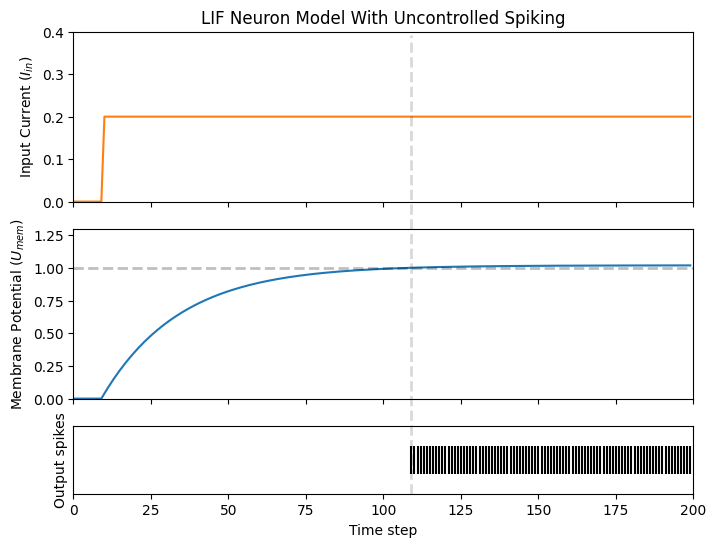

In [20]:
# Small step current input
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*0.2), 0)
mem = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron simulation
for step in range(num_steps):
  mem, spk = leaky_integrate_and_fire(mem, cur_in[step])
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, vline=109, ylim_max2=1.3,
                 title="LIF Neuron Model With Uncontrolled Spiking")

오 이런... - 출력 스파이크가 통제 불능 상태가 되었습니다! 리셋 메커니즘을 추가하는 것을 잊었기 때문입니다. 실제로 뉴런이 발화할 때마다 막 전위는 휴식 전위로 다시 과분극됩니다.

이 리셋 메커니즘을 뉴런에 구현했습니다:

In [25]:
# LIF w/Reset mechanism
def leaky_integrate_and_fire(mem, cur=0, threshold=1, time_step=1e-3, R=5.1, C=5e-3):
  tau_mem = R*C
  spk = (mem > threshold)
  mem = mem + (time_step/tau_mem)*(-mem + cur*R) - spk*threshold  # every time spk=1, subtract the threhsold
  return mem, spk

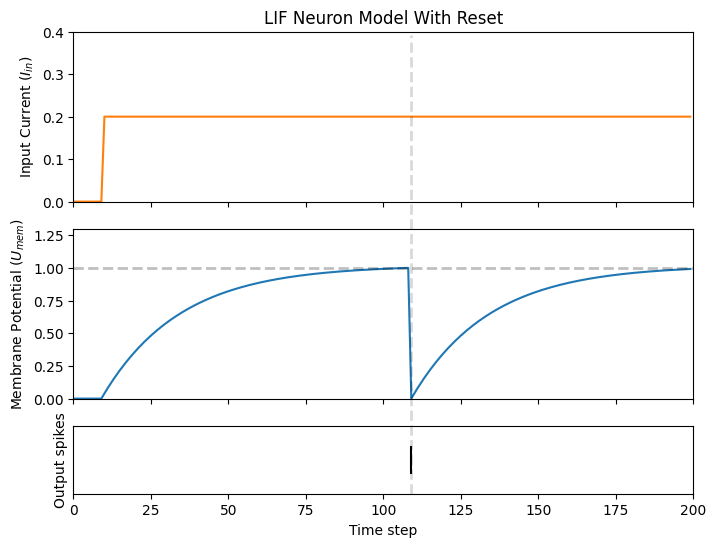

In [26]:
# Small step current input
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*0.2), 0)
mem = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron simulation
for step in range(num_steps):
  mem, spk = leaky_integrate_and_fire(mem, cur_in[step])
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, vline=109, ylim_max2=1.3,
                 title="LIF Neuron Model With Reset")

짠! 드디어 이제 제대로 작동하는 leaky integrate-and-fire (LIF) 뉴런 모델이 만들어졌습니다!

$I_{\rm in}=0.2 A$ 이고 $R<5 \Omega$ 인 경우, $I\times R < 1 V$ 입니다. `threshold=2` 이면 스파이크가 발생하지 않습니다. 다시 올라가서 값을 변경하고 테스트 해보세요.

이전과 마찬가지로, 모든 코드는 snnTorch에서 내장된 Lapicque neuron model을 호출하여 압축됩니다:

In [27]:
# Create the same neuron as before using snnTorch
lif2 = snn.Lapicque(R=5.1, C=5e-3, time_step=1e-3)

print(f"Membrane potential time constant: {lif2.R * lif2.C:.3f}s")

Membrane potential time constant: 0.025s


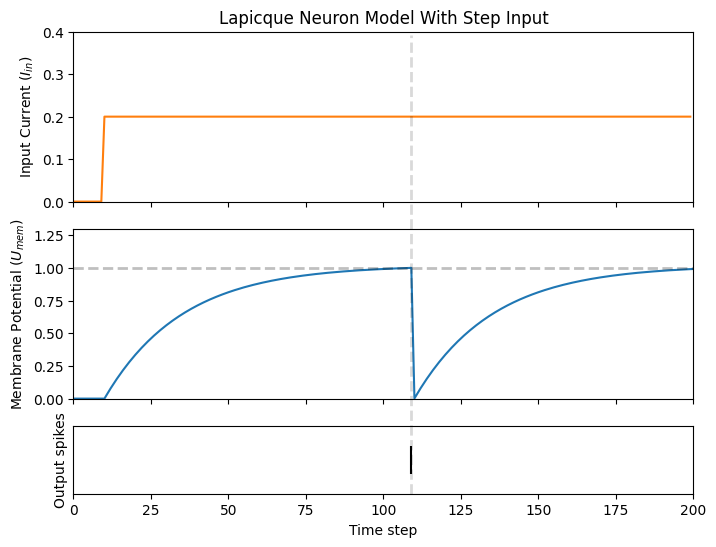

In [28]:
# Initialize inputs and outputs
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*0.2), 0)
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec = [mem]
spk_rec = [spk_out]

# Simulation run across 100 time steps.
for step in range(num_steps):
  spk_out, mem = lif2(cur_in[step], mem)
  mem_rec.append(mem)
  spk_rec.append(spk_out)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, vline=109, ylim_max2=1.3,
                 title="Lapicque Neuron Model With Step Input")

막 전위는 기하급수적으로 상승한 후 임계값에 도달하고, 이 시점에서 재설정됩니다. 대략 $105ms < t_{\rm spk} < 115ms$ 사이에서 발생합니다. 호기심에 스파이크 기록이 실제로 어떻게 구성되는지 살펴봅시다:

In [ ]:
print(spk_rec[105:115].view(-1))

스파이크가 없는 경우는 $S_{\rm out}=0$ 로 표시되며, 스파이크가 발생하는 경우는 $S_{\rm out}=1$ 입니다. 여기서 스파이크는 $S_{\rm out}[t=109]=1$ 에서 발생합니다. 이러한 각 항목이 텐서로 저장되는 이유가 궁금하다고요? 그것은 향후 튜토리얼에서 대규모 신경망을 시뮬레이션할 것이기 때문입니다. 각 항목에는 많은 뉴런의 스파이크 응답이 포함될 것이며, 텐서를 GPU 메모리에 로드하여 훈련 프로세스의 속도를 높일 수 있습니다.

$I_{\rm in}$ 이 증가하면 막 전위는 임계값 $U_{\rm thr}$ 에 더 빨리 접근합니다:

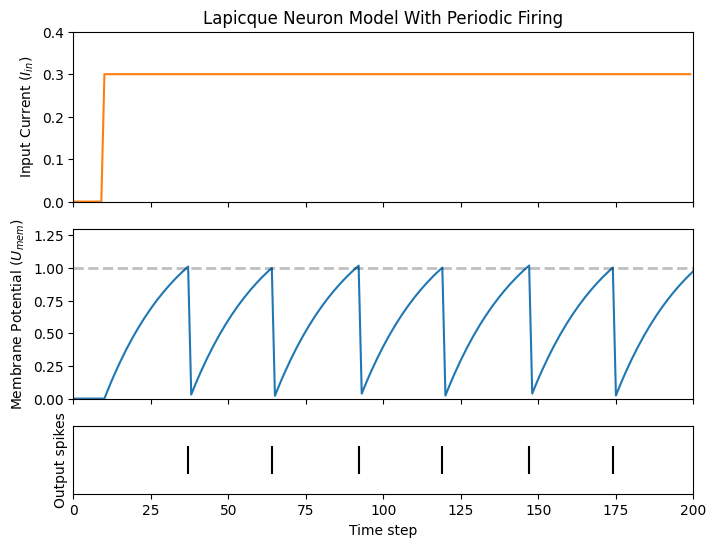

In [29]:
# Initialize inputs and outputs
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*0.3), 0)  # increased current
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec = [mem]
spk_rec = [spk_out]

# neuron simulation
for step in range(num_steps):
  spk_out, mem = lif2(cur_in[step], mem)
  mem_rec.append(mem)
  spk_rec.append(spk_out)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)


plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, ylim_max2=1.3,
                 title="Lapicque Neuron Model With Periodic Firing")

임계값을 낮춰도 비슷한 수준의 발화 빈도 증가를 유도할 수 있습니다. 이를 위해서는 새 뉴런 모델을 초기화해야 하지만 나머지 코드 블록은 위와 완전히 동일합니다:

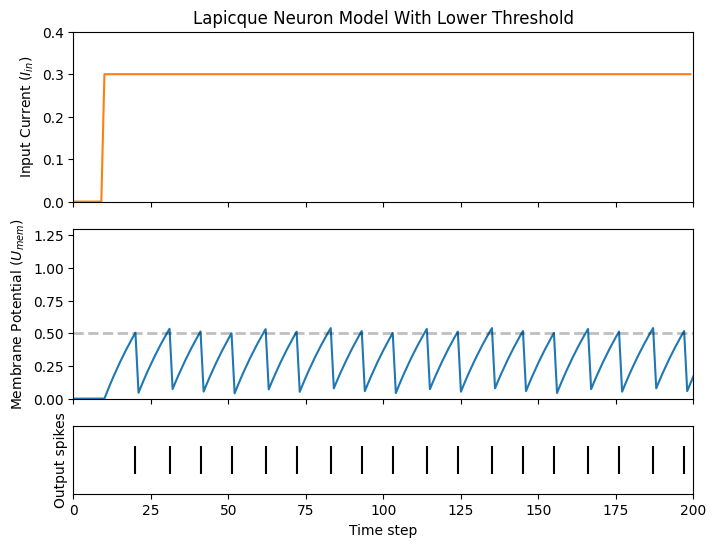

In [30]:
# neuron with halved threshold
lif3 = snn.Lapicque(R=5.1, C=5e-3, time_step=1e-3, threshold=0.5)

# Initialize inputs and outputs
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*0.3), 0)
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec = [mem]
spk_rec = [spk_out]

# Neuron simulation
for step in range(num_steps):
  spk_out, mem = lif3(cur_in[step], mem)
  mem_rec.append(mem)
  spk_rec.append(spk_out)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=0.5, ylim_max2=1.3,
                 title="Lapicque Neuron Model With Lower Threshold")

이것이 바로 정전류(constant current) 주입(injection)에서 일어나는 일입니다. 그러나 심층 신경망과 생물학적 뇌 모두에서 대부분의 뉴런은 다른 뉴런과 연결되어 있습니다. 따라서 정전류를 주입하는 것보다 스파이크를 받을 가능성이 더 높습니다.

## 3.5 Lapicque: Spike Inputs

[Tutorial 1](https://colab.research.google.com/github/jeshraghian/snntorch/blob/tutorials/examples/tutorial_1_spikegen.ipynb) 에서 배운 몇가지 기술(snntorch.spikegen 모듈)을 활용하여 무작위로 생성된 입력 스파이크를 만들어 보겠습니다.

In [31]:
# Create a 1-D random spike train. Each element has a probability of 40% of firing.
spk_in = spikegen.rate_conv(torch.ones((num_steps)) * 0.40)

다음 코드 블록을 실행하여 얼마나 많은 스파이크가 생성되었는지 확인합니다.

There are 91 total spikes out of 200 time steps.


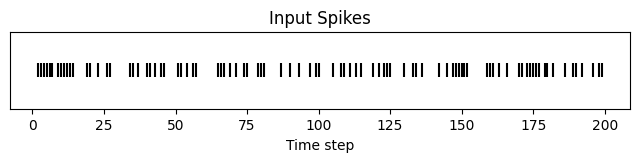

In [32]:
print(f"There are {int(sum(spk_in))} total spikes out of {len(spk_in)} time steps.")

fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

splt.raster(spk_in.reshape(num_steps, -1), ax, s=100, c="black", marker="|")
plt.title("Input Spikes")
plt.xlabel("Time step")
plt.yticks([])
plt.show()

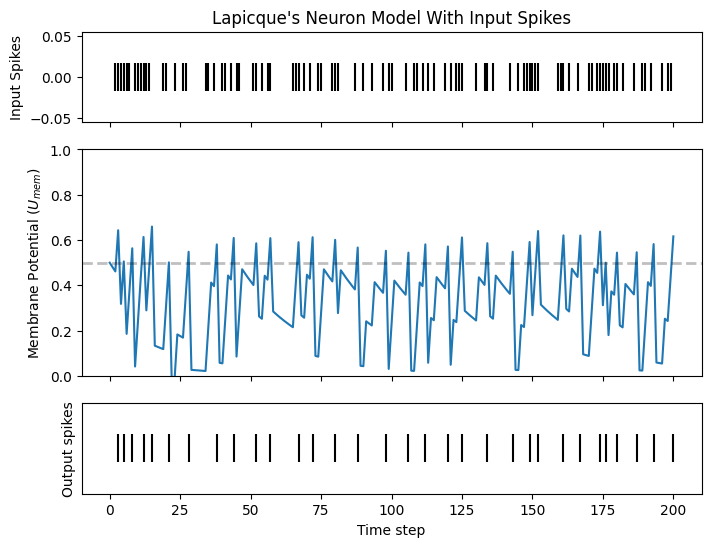

In [33]:
# Initialize inputs and outputs
mem = torch.ones(1)*0.5
spk_out = torch.zeros(1)
mem_rec = [mem]
spk_rec = [spk_out]

# Neuron simulation
for step in range(num_steps):
  spk_out, mem = lif3(spk_in[step], mem)
  spk_rec.append(spk_out)
  mem_rec.append(mem)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_spk_mem_spk(spk_in, mem_rec, spk_out, "Lapicque's Neuron Model With Input Spikes")

## 3.6 Lapicque: Reset Mechanisms
이미 처음부터 리셋 메커니즘을 구현했지만 조금 더 자세히 살펴봅시다. 막 전위의 급격한 하락은 스파이크 발생의 감소를 촉진하여 뇌의 전력 효율성에 대한 이론의 일부를 보완합니다. 생물학적으로 이러한 막 전위의 강하를 '과분극'이라고 합니다. 그 후에는 뉴런에서 또 다른 스파이크를 이끌어내는 것이 순간적으로 더 어려워집니다. 여기서는 리셋 메커니즘을 사용하여 과분극을 모델링합니다.

리셋 메커니즘을 구현하는 방법에는 두 가지가 있습니다:

1.  *빼기를 통한 리셋* (default) $-$ 스파이크가 생성될 때마다 막 전위에서 임계값을 뺍니다;
2.  *0을 통한 리셋* $-$ 스파이크가 생성될 때마다 막 전위를 0으로 강제 설정합니다.
3.  *리셋하지 않음* $-$ 아무 조치도 취하지 않고, 통제되지 않은 채로 fire하도록 내버려 두는 것입니다.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_5_reset.png?raw=true' width="450">
</center>

다른 뉴런 모델을 인스턴스화하여 리셋 메커니즘을 번갈아 사용하는 방법을 시연합니다.
기본적으로 snnTorch 뉴런 모델은 `reset_mechanism = "subtract"`를 사용합니다. 이는 `reset_mechanism = "zero"` 인수를 전달하여 명시적으로 재정의할 수 있습니다.

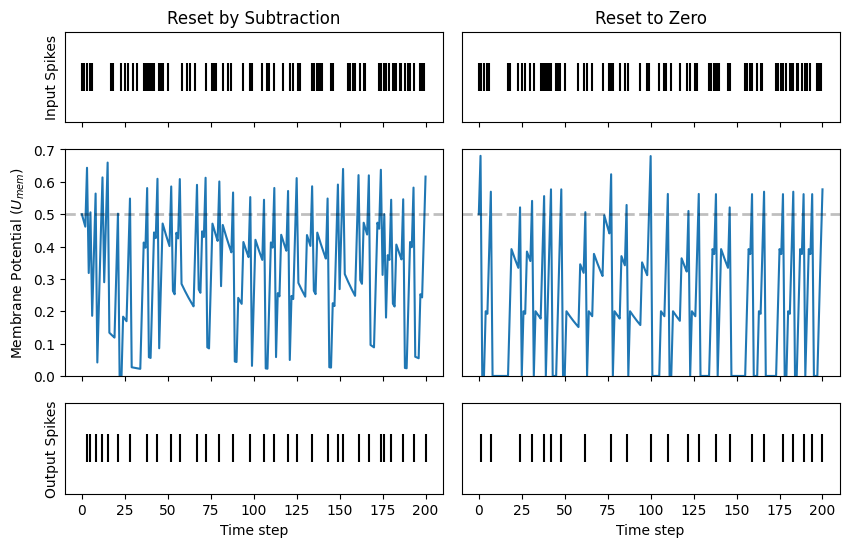

In [34]:
# Neuron with reset_mechanism set to "zero"
lif4 = snn.Lapicque(R=5.1, C=5e-3, time_step=1e-3, threshold=0.5, reset_mechanism="zero")

# Initialize inputs and outputs
spk_in = spikegen.rate_conv(torch.ones((num_steps)) * 0.40)
mem = torch.ones(1)*0.5
spk_out = torch.zeros(1)
mem_rec0 = [mem]
spk_rec0 = [spk_out]

# Neuron simulation
for step in range(num_steps):
  spk_out, mem = lif4(spk_in[step], mem)
  spk_rec0.append(spk_out)
  mem_rec0.append(mem)

# convert lists to tensors
mem_rec0 = torch.stack(mem_rec0)
spk_rec0 = torch.stack(spk_rec0)

plot_reset_comparison(spk_in, mem_rec, spk_rec, mem_rec0, spk_rec0)

특히 멤브레인 전위가 임계값에 도달한 직후에 멤브레인 전위의 변화를 주의 깊게 관찰하세요. '0으로 초기화'의 경우, 스파이크가 발생할 때마다 막 전위가 0으로 강제로 되돌아가는 것을 볼 수 있습니다.

그렇다면 어느 쪽이 더 나을까요? "빼기"(`reset_mechanism`의 기본값)를 적용하면 멤브레인이 임계값을 얼마나 초과했는지를 무시하지 않기 때문에 손실이 적습니다.

반면에 `"0"`으로 하드 리셋을 적용하면 전용 뉴로모픽 하드웨어에서 실행할 때 희소성을 높이고 잠재적으로 전력 소비를 줄일 수 있습니다. 두 가지 옵션 모두 실험해 볼 수 있습니다.

여기까지 LIF 뉴런 모델의 기본에 대해 알아보았습니다!

# Conclusion

실제로는 이 뉴런 모델을 신경망 훈련에 사용하지 않을 것입니다. 라피크 LIF 모델에는 조정할 하이퍼파라미터가 많이 추가되었습니다: $R$, $C$, $\Delta t$, $U_{\rm thr}$, 그리고 리셋 메커니즘을 선택할 수 있습니다. 이 모든 것이 조금은 어렵습니다. 그래서 [다음 튜토리얼](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)에서는 이러한 하이퍼파라미터를 대부분 제거하고 대규모 딥러닝에 더 적합한 뉴런 모델을 소개합니다.

참고로 관련 문서는 [여기](https://snntorch.readthedocs.io/en/latest/snntorch.html)에서 확인할 수 있습니다.

이 프로젝트가 마음에 드신다면 GitHub에서 리포지토리의 ⭐(Star)를 눌러주세요.

## Further Reading
* [Check out the snnTorch GitHub project here.](https://github.com/jeshraghian/snntorch)
* [snnTorch documentation](https://snntorch.readthedocs.io/en/latest/snntorch.html) of the Lapicque, Leaky, Synaptic, and Alpha models
* [*Neuronal Dynamics:
From single neurons to networks and models of cognition*](https://neuronaldynamics.epfl.ch/index.html) by
Wulfram Gerstner, Werner M. Kistler, Richard Naud and Liam Paninski.
* [Theoretical Neuroscience: Computational and Mathematical Modeling of Neural Systems](https://mitpress.mit.edu/books/theoretical-neuroscience) by Laurence F. Abbott and Peter Dayan